# Análise Exploratória de Grafos

## Resumo
**Este trabalho demonstra como a análise sistemática de grafos pode revelar padrões universais e específicos em sistemas complexos, fornecendo subsídios valiosos para pesquisa, inovação e tomada de decisão em múltiplos domínios.**

## Introdução

Este relatório apresenta uma análise exploratória detalhada de diversas redes complexas, utilizando técnicas modernas de ciência de dados e análise de grafos. O objetivo principal é investigar as propriedades estruturais, padrões de conectividade, medidas de centralidade e comunidades presentes em diferentes tipos de redes reais, abrangendo domínios como biologia, infraestrutura, informação, transporte e redes sociais.

A análise foi conduzida de forma sistemática, empregando ferramentas consagradas como NetworkX, Pandas, Matplotlib e Seaborn, além de funções customizadas para amostragem eficiente de grandes grafos. O estudo contempla desde a inspeção inicial dos dados até comparações quantitativas entre as redes, buscando identificar características distintivas e potenciais aplicações.

O workflow executado neste trabalho incluiu:

- **Carregamento e inspeção dos dados**: Utilização de funções robustas para leitura flexível dos arquivos de edgelist, tratamento de diferentes tipos de nós e verificação de integridade dos dados.
- **Amostragem conectada de grafos grandes**: Implementação de métodos de amostragem por BFS e random-walk para garantir subgrafos representativos e conectados, viabilizando análises avançadas mesmo em redes de grande porte.
- **Cálculo de propriedades básicas**: Extração de métricas fundamentais como número de nós, arestas, densidade, grau médio, conectividade, componentes conexas, diâmetro e distância média.
- **Visualização da distribuição de graus**: Geração de histogramas log-log para identificar padrões de distribuição e presença de hubs em diferentes redes.
- **Cálculo de medidas de centralidade**: Avaliação de centralidades de grau, betweenness, closeness, eigenvector, katz e pagerank, com análise estatística e visualização dos resultados.
- **Visualização dos grafos**: Criação de visualizações dos subgrafos mais relevantes, destacando os nós centrais e padrões de conectividade por meio de layouts adequados.
- **Detecção de comunidades**: Aplicação do algoritmo de Louvain para identificar clusters e comunidades, cálculo de modularidade e análise do tamanho das comunidades.
- **Análise comparativa**: Construção de tabelas e gráficos para comparar propriedades estruturais, centralidades e modularidade entre diferentes tipos de redes, destacando padrões universais e assinaturas topológicas específicas.
- **Discussão dos resultados**: Interpretação dos achados em termos de implicações práticas, limitações metodológicas e sugestões para estudos futuros.

Os grafos analisados incluem:

- **Redes Sociais**: colaboração, atores, emails, chamadas telefônicas
- **Redes Biológicas**: proteínas, metabolismo
- **Redes de Infraestrutura**: internet, rede elétrica
- **Redes de Informação**: citações, web
- **Rede de Transporte**: mapa do metrô de Londres (análise extra indicada pelo professor)

Cada etapa do trabalho foi documentada com rigor, incluindo justificativas metodológicas, visualizações e interpretações dos resultados. Ao final, são apresentados insights relevantes para cada tipo de rede, bem como sugestões para estudos futuros e aplicações práticas.

Este relatório visa servir como referência para pesquisadores, profissionais e estudantes interessados em análise de redes complexas, oferecendo uma visão abrangente e comparativa sobre o comportamento e as propriedades dos principais tipos de grafos presentes em sistemas reais.


## 1. Import Required Libraries

Importando as bibliotecas necessárias para análise de grafos.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import os
from pathlib import Path
from collections import deque

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configurar tamanho das figuras
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def sample_large_graph(G, name, max_nodes=5000, seed=None, method="bfs"):
    """
    Amostragem conectada de grafos grandes, garantindo subgrafo conexo:
    1) Extrai LCC do grafo original;
    2) Se a LCC > max_nodes, faz amostragem conectada por BFS ou random-walk;
    3) Se ainda desconexo, extrai LCC final (backup).

    Parâmetros:
    -----------
    G : networkx.Graph
        Grafo original
    name : str
        Nome do grafo para logs
    max_nodes : int
        Tamanho máximo da amostra (default: 5000)
    seed : int ou None
        Semente para reprodutibilidade
    method : str
        "bfs" para BFS sampling (conexo), "rw" para random-walk (conexo)

    Retorna:
    --------
    G_out : networkx.Graph
        Subgrafo resultante, conexo
    was_sampled : bool
        True se houve amostragem, False se apenas LCC usado
    """
    # 1) Extrair LCC do original
    if nx.is_connected(G):
        G_lcc = G
        print(f"  {name}: Grafo original é conexo; usando direto.")
    else:
        nodes_lcc = max(nx.connected_components(G), key=len)
        G_lcc = G.subgraph(nodes_lcc).copy()
        print(f"  {name}: LCC inicial com {G_lcc.number_of_nodes()} nós.")

    # 2) Se não precisa amostrar, retorna LCC
    if G_lcc.number_of_nodes() <= max_nodes:
        return G_lcc, False

    # Amostragem conectada
    rng = np.random.default_rng(seed)
    if method == "rw":
        # Random Walk sampling
        start = rng.choice(list(G_lcc.nodes()))
        visited = [start]
        current = start
        while len(visited) < max_nodes:
            neighbors = list(G_lcc.neighbors(current))
            if neighbors:
                current = rng.choice(neighbors)
                if current not in visited:
                    visited.append(current)
            else:
                current = rng.choice(visited)
        sample_nodes = visited
        print(f"  {name}: Amostragem por random-walk com {len(sample_nodes)} nós.")
    else:
        # BFS sampling
        start = rng.choice(list(G_lcc.nodes()))
        q = deque([start])
        visited = {start}
        while q and len(visited) < max_nodes:
            u = q.popleft()
            for v in G_lcc.neighbors(u):
                if v not in visited:
                    visited.add(v)
                    q.append(v)
                    if len(visited) >= max_nodes:
                        break
        sample_nodes = list(visited)
        print(f"  {name}: Amostragem BFS com {len(sample_nodes)} nós.")

    G_out = G_lcc.subgraph(sample_nodes).copy()

    # 3) Garantir conectividade (backup)
    if not nx.is_connected(G_out):
        nodes_final = max(nx.connected_components(G_out), key=len)
        G_out = G_out.subgraph(nodes_final).copy()
        print(f"  {name}: Subgrafo desconexo, usando LCC final ({G_out.number_of_nodes()} nós).")

    return G_out, True

## 2. Load and Inspect Graph Data

Carregando os dados dos grafos e realizando uma inspeção inicial da estrutura dos dados.

In [2]:
import networkx as nx
from pathlib import Path

# --- Configuração ---
# Definir o diretório dos dados
data_dir = Path("networks")

# Lista dos arquivos de grafo a serem processados
GRAPH_FILES = [
    "extra - londonTubeMap.edgelist.txt",
    "actor.edgelist.txt",
    "citation.edgelist.txt", 
    "collaboration.edgelist.txt",
    "email.edgelist.txt",
    "internet.edgelist.txt",
    "metabolic.edgelist.txt",
    "phonecalls.edgelist.txt",
    "powergrid.edgelist.txt",
    "protein.edgelist.txt",
    "www.edgelist.txt",
]

# --- Função de Carregamento ---
def load_graph(filename: str):
    """
    Carrega um grafo a partir de um arquivo edgelist, 
    lidando com nós inteiros ou strings e verificando arquivos Git LFS.
    Retorna o objeto do grafo ou None em caso de falha.
    """
    file_path = data_dir / filename
    
    # 1. Verificação de existência e ponteiro Git LFS
    if not file_path.exists():
        print(f"Erro: Arquivo '{filename}' não encontrado.")
        return None
    
    with open(file_path, 'r', encoding='utf-8') as f:
        if 'version https://git-lfs.github.com/spec/v1' in f.read(200):
            print(f"Aviso: O arquivo '{filename}' é um ponteiro Git LFS - dados não disponíveis.")
            return None
            
    # 2. Carregamento flexível do grafo (Lógica Corrigida)
    try:
        # Primeira tentativa: carregar como nós inteiros
        G = nx.read_edgelist(file_path, nodetype=int)
        print(f"  ✓ Carregado como grafo com nós inteiros.")
        return G
    except Exception as e:
        # Se a primeira tentativa falhar, verificar o motivo do erro
        if "Failed to convert" in str(e):
            # O erro foi de conversão. Tentar novamente como string.
            print(f"  ⓘ Nós não são inteiros. Tentando carregar como strings...")
            try:
                G = nx.read_edgelist(file_path) # Padrão é nodetype=str
                print(f"  ✓ Carregado como grafo com nós strings.")
                return G
            except Exception as e2:
                # Se a segunda tentativa também falhar
                print(f"  ✗ Erro interno ao carregar {filename} como strings: {e2}")
                return None
        else:
            # O erro foi outro que não de conversão
            print(f"  ✗ Erro inesperado ao carregar {filename}: {e}")
            return None

# --- Fluxo Principal para Notebook ---
graphs = {}
print("Iniciando o carregamento dos grafos...\n" + "-"*30)

for filename in GRAPH_FILES:
    print(f"Processando '{filename}'...")
    graph = load_graph(filename)
    
    if graph:
        graph_name = filename.replace('.edgelist.txt', '')
        graphs[graph_name] = graph
        print(f"    - {graph.number_of_nodes()} nós, {graph.number_of_edges()} arestas.\n")
    else:
        print(f"    - Falha no carregamento. Pulando este arquivo.\n")

print("-" * 30 + "\nResumo do Carregamento:")
print(f"Total de grafos carregados com sucesso: {len(graphs)}")
for name, graph in graphs.items():
    print(f"  - '{name}': {graph.number_of_nodes()} nós e {graph.number_of_edges()} arestas.")

Iniciando o carregamento dos grafos...
------------------------------
Processando 'extra - londonTubeMap.edgelist.txt'...
  ⓘ Nós não são inteiros. Tentando carregar como strings...
  ✓ Carregado como grafo com nós strings.
    - 359 nós, 417 arestas.

Processando 'actor.edgelist.txt'...
  ✓ Carregado como grafo com nós inteiros.
    - 702388 nós, 29397908 arestas.

Processando 'citation.edgelist.txt'...
  ✓ Carregado como grafo com nós inteiros.
    - 449673 nós, 4685576 arestas.

Processando 'collaboration.edgelist.txt'...
  ✓ Carregado como grafo com nós inteiros.
    - 23133 nós, 93439 arestas.

Processando 'email.edgelist.txt'...
  ✓ Carregado como grafo com nós inteiros.
    - 57194 nós, 93090 arestas.

Processando 'internet.edgelist.txt'...
  ✓ Carregado como grafo com nós inteiros.
    - 192244 nós, 609066 arestas.

Processando 'metabolic.edgelist.txt'...
  ✓ Carregado como grafo com nós inteiros.
    - 1039 nós, 4741 arestas.

Processando 'phonecalls.edgelist.txt'...
  ✓ Carre

## 3. Basic Graph Properties

Calculando e exibindo propriedades básicas dos grafos como número de nós, arestas, densidade e tipo de grafo.

In [3]:
def analyze_graph(G, name="graph", max_nodes=5000, seed=None, method="bfs"):
    """
    Calcula métricas usando sample_large_graph com amostragem conectada.
    """
    print(f"\n=== ANÁLISE DE {name.upper()} ===")
    G_use, was_sampled = sample_large_graph(G, name, max_nodes, seed, method)
    if was_sampled:
        print(f"  Nota: analisando subgrafo com {G_use.number_of_nodes()} nós.")

    # Métricas básicas
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G_use)
    degrees = list(dict(G_use.degree()).values())
    avg_degree = np.mean(degrees)
    is_conn = nx.is_connected(G)
    n_comps = nx.number_connected_components(G_use)

    # Preparar LCC para distâncias
    if n_comps > 1:
        comp = max(nx.connected_components(G_use), key=len)
        sub = G_use.subgraph(comp)
    else:
        sub = G_use

    # Métricas avançadas
    deg_seq = sorted(degrees, reverse=True)
    max_deg = deg_seq[0]
    min_deg = deg_seq[-1]
    deg_std = np.std(deg_seq)
    avg_path = nx.average_shortest_path_length(sub)
    diam = nx.diameter(sub)

    print(f"Vértices: {n_nodes}, Arestas: {n_edges}")
    print(f"Densidade: {density:.4f}, Grau médio: {avg_degree:.4f}")
    print(f"LCC: {sub.number_of_nodes()} nós")
    print(f"Grau(min–máx): {min_deg}–{max_deg}, σ: {deg_std:.4f}")
    print(f"Distância média: {avg_path:.4f}, Diâmetro: {diam}")

    return {
        "name": name,
        "nodes": n_nodes, # tamanho do grafo original
        "edges": n_edges, # numero de links do grafo original
        "density": density, # quão próximo este grafo está de ser totalmente conectado
        "avg_degree": avg_degree, # quão conectados estão os pontos individuais do grafo
        "is_connected": is_conn, # se o grafo original é conexo
        "n_components": n_comps, # numero de componentes conexas
        "largest_cc_size": sub.number_of_nodes(), # tamanho da maior componente conexa
        "max_degree": max_deg, # o vértice com o maior número de arestas incidentes
        "min_degree": min_deg, # o vértice com o menor número de arestas incidentes
        "degree_std": deg_std, # quantifica o quão uniformemente os graus dos vértices estão distribuídos em relação ao grau médio
        "avg_path_length": avg_path, # distância média entre todos os pares de nós na rede.
        "diameter": diam # A maior distância entre todos os pares de nós na rede, representando o tamanho geral da rede.
    }

# Uso:
res = [analyze_graph(g, n, max_nodes=10000, seed=42, method="bfs") for n, g in graphs.items()]
df_basic_properties = pd.DataFrame(res).set_index('name').round(4)



=== ANÁLISE DE EXTRA - LONDONTUBEMAP ===
  extra - londonTubeMap: Grafo original é conexo; usando direto.
Vértices: 359, Arestas: 417
Densidade: 0.0065, Grau médio: 2.3231
LCC: 359 nós
Grau(min–máx): 1–7, σ: 0.9566
Distância média: 14.0539, Diâmetro: 39

=== ANÁLISE DE ACTOR ===
  actor: LCC inicial com 684571 nós.
  actor: Amostragem BFS com 10000 nós.
  Nota: analisando subgrafo com 10000 nós.
Vértices: 702388, Arestas: 29397908
Densidade: 0.0069, Grau médio: 68.8512
LCC: 10000 nós
Grau(min–máx): 1–1354, σ: 91.6355
Distância média: 2.9579, Diâmetro: 5

=== ANÁLISE DE CITATION ===
  citation: LCC inicial com 448817 nós.
  citation: Amostragem BFS com 10000 nós.
  Nota: analisando subgrafo com 10000 nós.
Vértices: 449673, Arestas: 4685576
Densidade: 0.0011, Grau médio: 10.7994
LCC: 10000 nós
Grau(min–máx): 1–739, σ: 17.3367
Distância média: 4.3193, Diâmetro: 7

=== ANÁLISE DE COLLABORATION ===
  collaboration: LCC inicial com 21363 nós.
  collaboration: Amostragem BFS com 10000 nós.
 

## 4. Graph Degrees Histogram

Plotando o a distribuição dos graus dos grafos

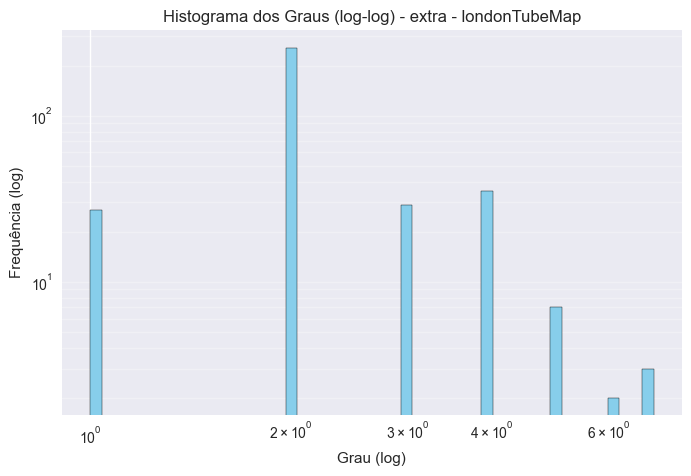

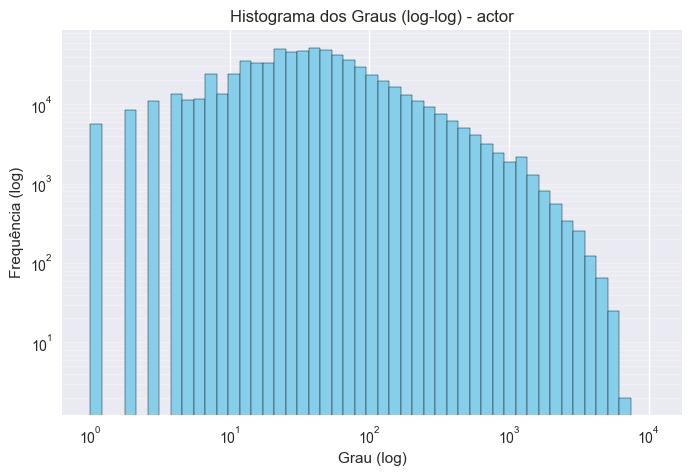

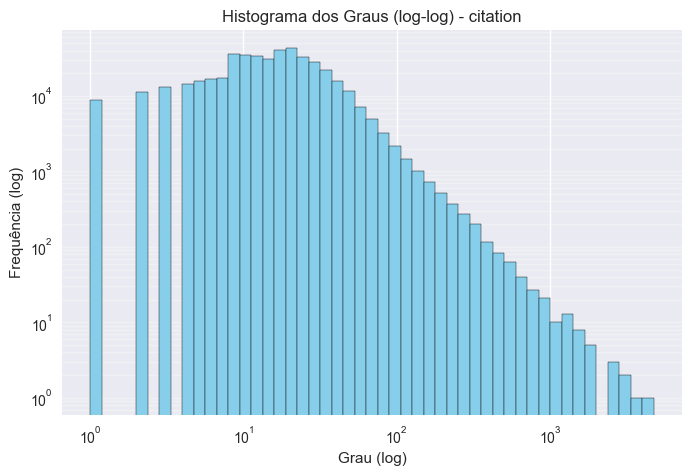

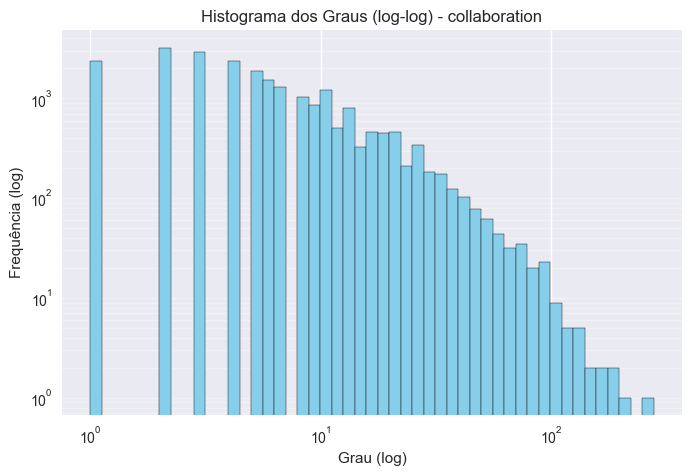

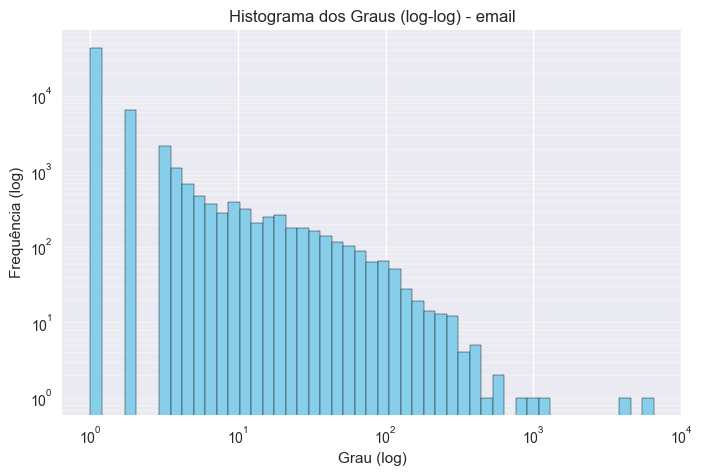

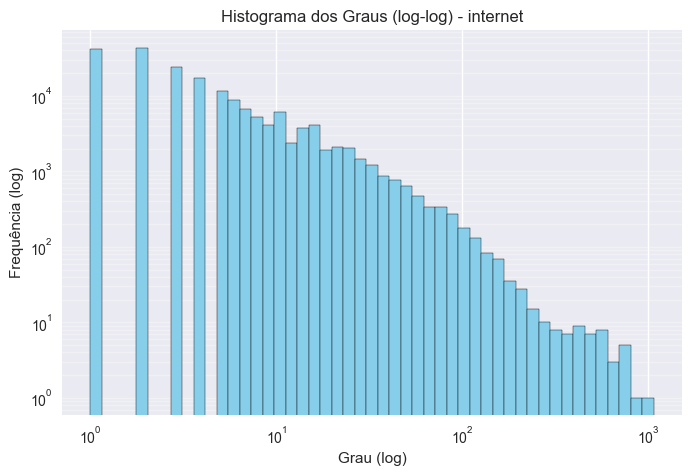

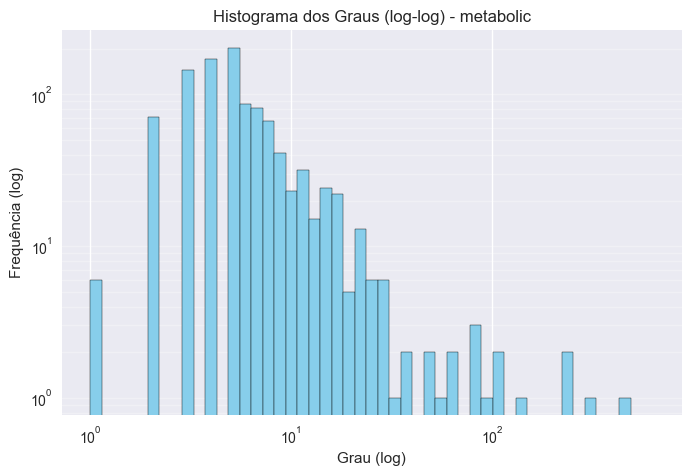

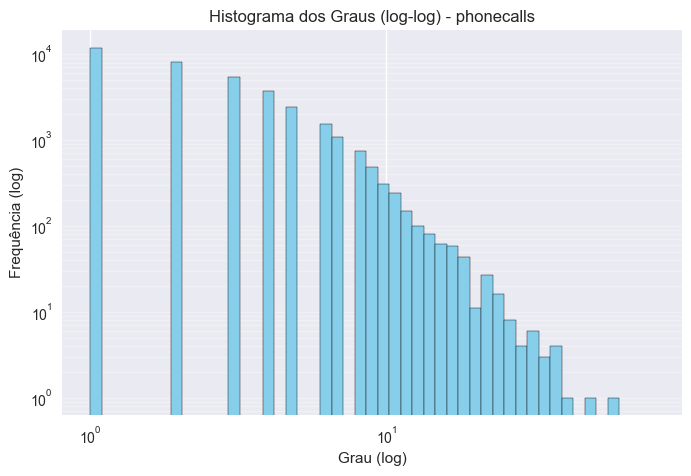

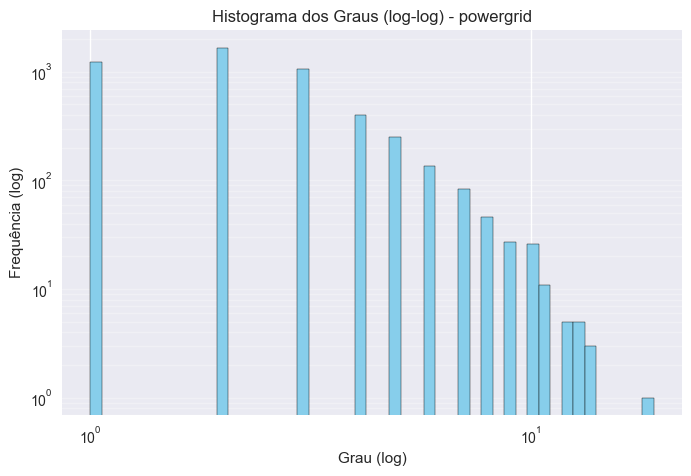

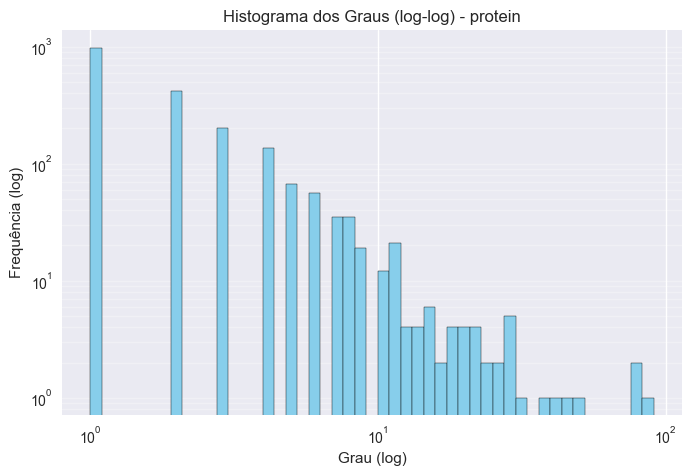

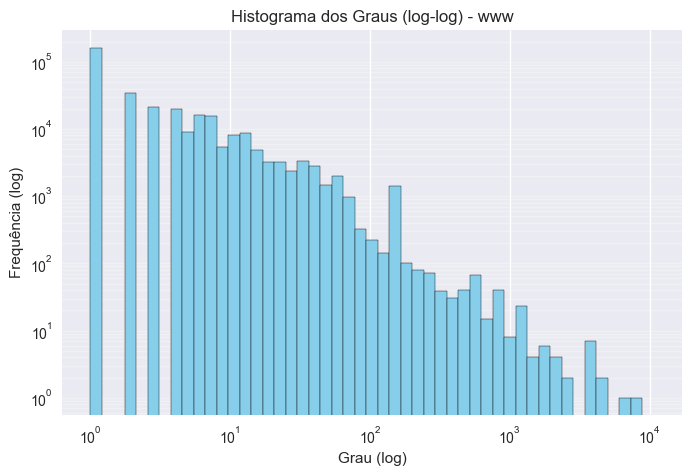

In [4]:
for name, G in graphs.items():
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(8, 5))
    plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), color='skyblue', edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Histograma dos Graus (log-log) - {name}')
    plt.xlabel('Grau (log)')
    plt.ylabel('Frequência (log)')
    plt.grid(axis='y', alpha=0.3, which='both')
    plt.show()


## 5. Centrality Measures

Calculando e interpretando várias medidas de centralidade como grau, betweenness, closeness e eigenvector centrality.

Calculando protein
  protein: LCC inicial com 1647 nós.
  [protein] Centralidades em subgrafo de 1647 nós (amostrado=False)
    Betweenness: amostrada (k=500)
Médias das centralidades:
  eigenvector: 0.008448
  katz: 0.024603
  pagerank: 0.000607
  betweenness: 0.002852


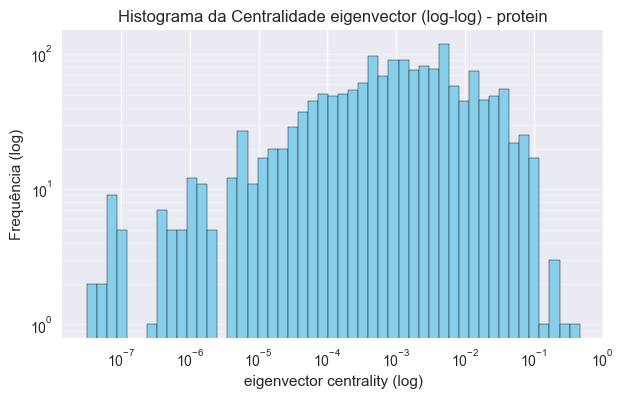

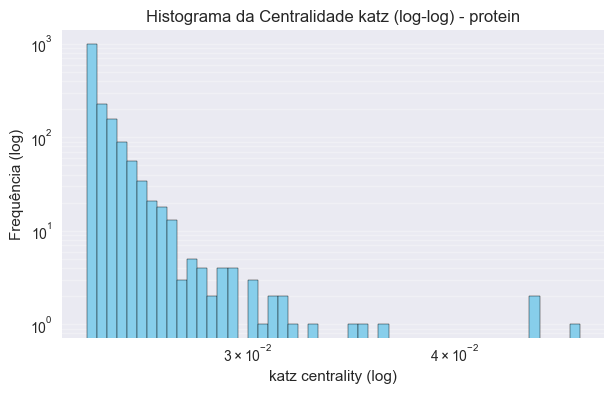

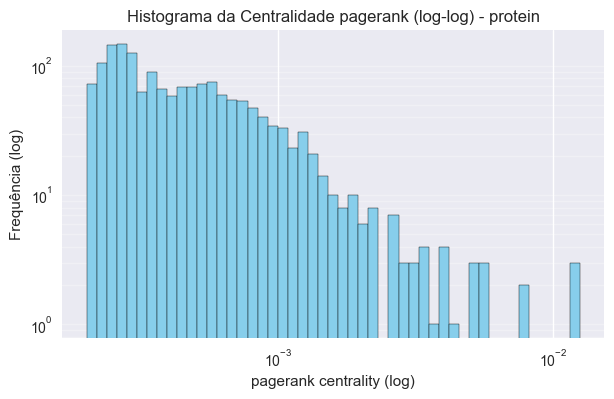

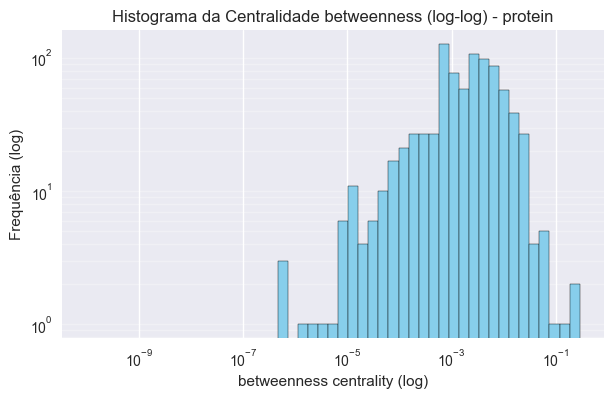

Calculando extra - londonTubeMap
  extra - londonTubeMap: Grafo original é conexo; usando direto.
  [extra - londonTubeMap] Centralidades em subgrafo de 359 nós (amostrado=False)
    Betweenness: exata (k=359)
Médias das centralidades:
  eigenvector: 0.016144
  katz: 0.052776
  pagerank: 0.002786
  betweenness: 0.036566


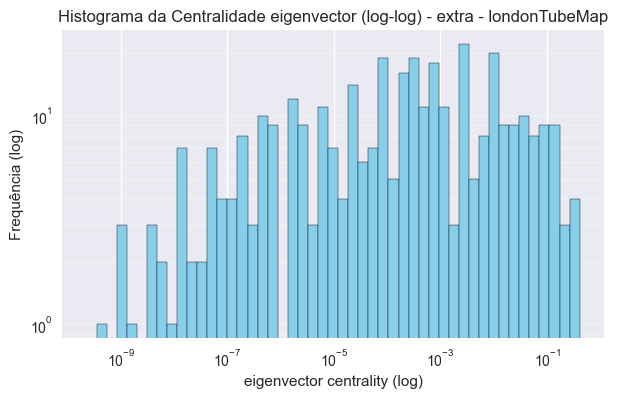

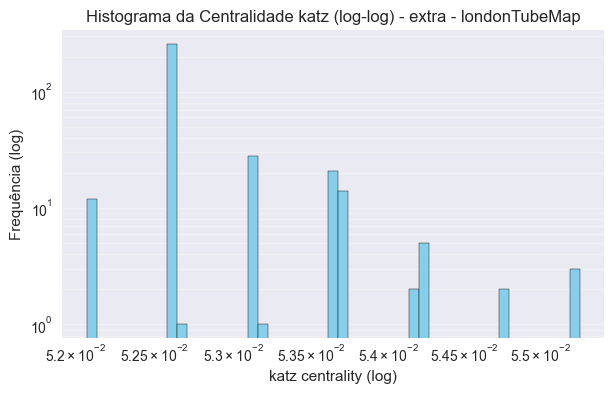

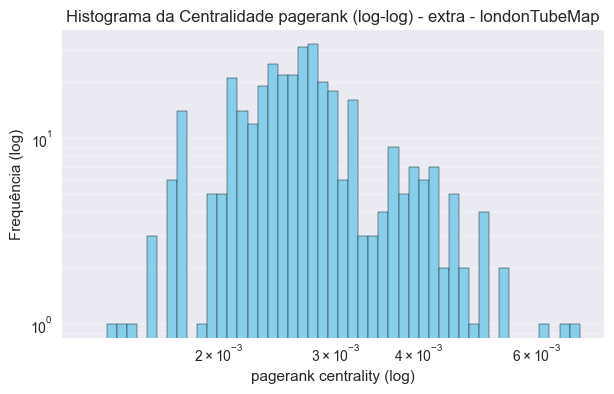

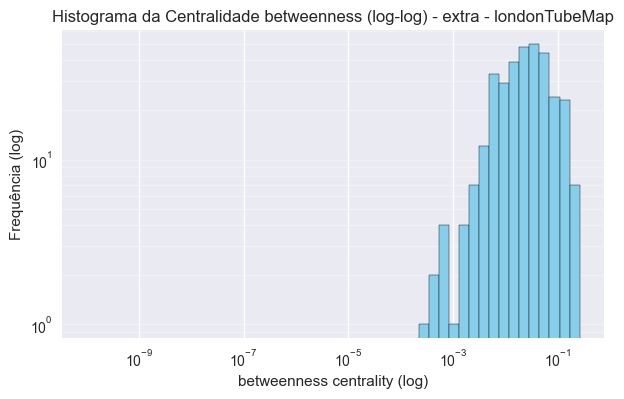

In [5]:
def calculate_centralities(
    G, name,
    max_nodes=5000,
    seed=None,
    method="bfs",
    betweenness_samples=500
):
    """
    Calcula centralidades:
      - eigenvector
      - katz
      - pagerank
      - betweenness (amostrada se grafo grande)
    Plota histogramas e retorna médias.
    """
    G_sub, sampled = sample_large_graph(
        G, name, max_nodes=max_nodes,
        seed=seed, method=method
    )
    n = G_sub.number_of_nodes()
    print(f"  [{name}] Centralidades em subgrafo de {n} nós (amostrado={sampled})")

    centralities = {}

    # Eigenvector centrality
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(G_sub, max_iter=1000, tol=1e-06)
    except Exception as e:
        print(f"    Aviso eigenvector failed: {e}")

    # Katz centrality
    try:
        centralities['katz'] = nx.katz_centrality(G_sub, alpha=0.01, beta=1.0, max_iter=1000, tol=1e-06)
    except Exception as e:
        print(f"    Aviso katz failed: {e}")

    # PageRank
    try:
        centralities['pagerank'] = nx.pagerank(G_sub, alpha=0.85, max_iter=1000, tol=1e-06)
    except Exception as e:
        print(f"    Aviso pagerank failed: {e}")

    # Betweenness: usa k toda vez para menor custo
    k = min(betweenness_samples, n)
    if n <= k:
        centralities['betweenness'] = nx.betweenness_centrality(G_sub)
    else:
        centralities['betweenness'] = nx.betweenness_centrality(G_sub, k=k, seed=seed)
    print(f"    Betweenness: {'exata' if n<=k else 'amostrada'} (k={k})")

    # Converter para DataFrame padronizado
    df_centrality = pd.DataFrame(centralities)
    df_centrality.index.name = 'node'

    # Calcular médias
    means = df_centrality.mean().to_dict()
    print("Médias das centralidades:")
    for key, val in means.items():
        print(f"  {key}: {val:.6f}")

    # Plotar histogramas em escala logarítmica
    for col in df_centrality.columns:
        plt.figure(figsize=(7,4))
        plt.hist(df_centrality[col], bins=np.logspace(np.log10(df_centrality[col].min()+1e-10), np.log10(df_centrality[col].max()+1e-10), 50), color='skyblue', edgecolor='black')
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'Histograma da Centralidade {col} (log-log) - {name}')
        plt.xlabel(f'{col} centrality (log)')
        plt.ylabel('Frequência (log)')
        plt.grid(axis='y', alpha=0.3, which='both')
        plt.show()

    return df_centrality, means

# Exemplo de uso
results = {}
means_results = {}
for gname in ['protein', "extra - londonTubeMap"]: #,'metabolic','powergrid','email']:
    if gname in graphs:
        print(f"Calculando {gname}")
        df_cent, means = calculate_centralities(
            graphs[gname], gname,
            max_nodes=10000, seed=42,
            method='bfs',
            betweenness_samples=500
        )
        results[gname] = df_cent
        means_results[gname] = means


## 6. Graph Visualization

Criando várias visualizações dos grafos usando diferentes algoritmos de layout e opções de estilo.

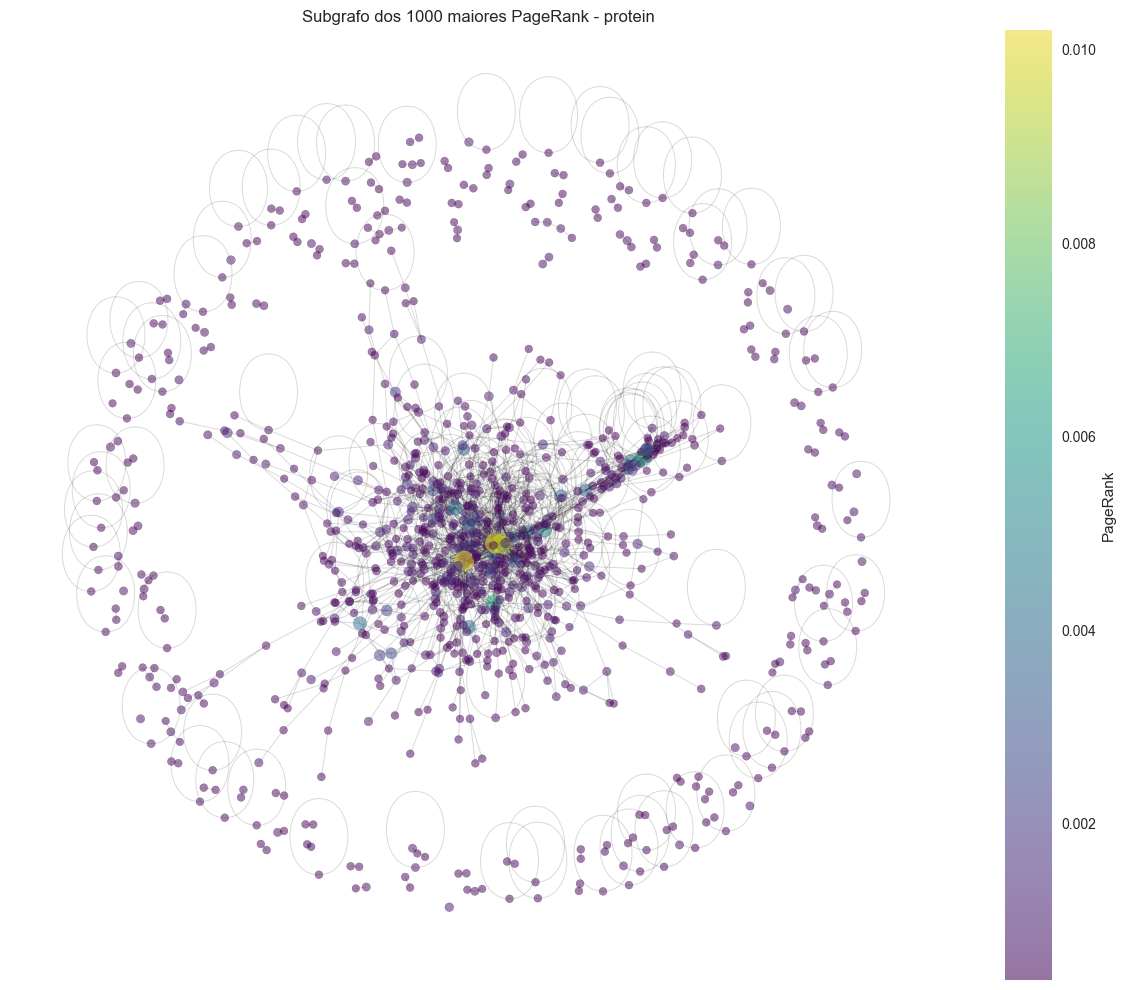

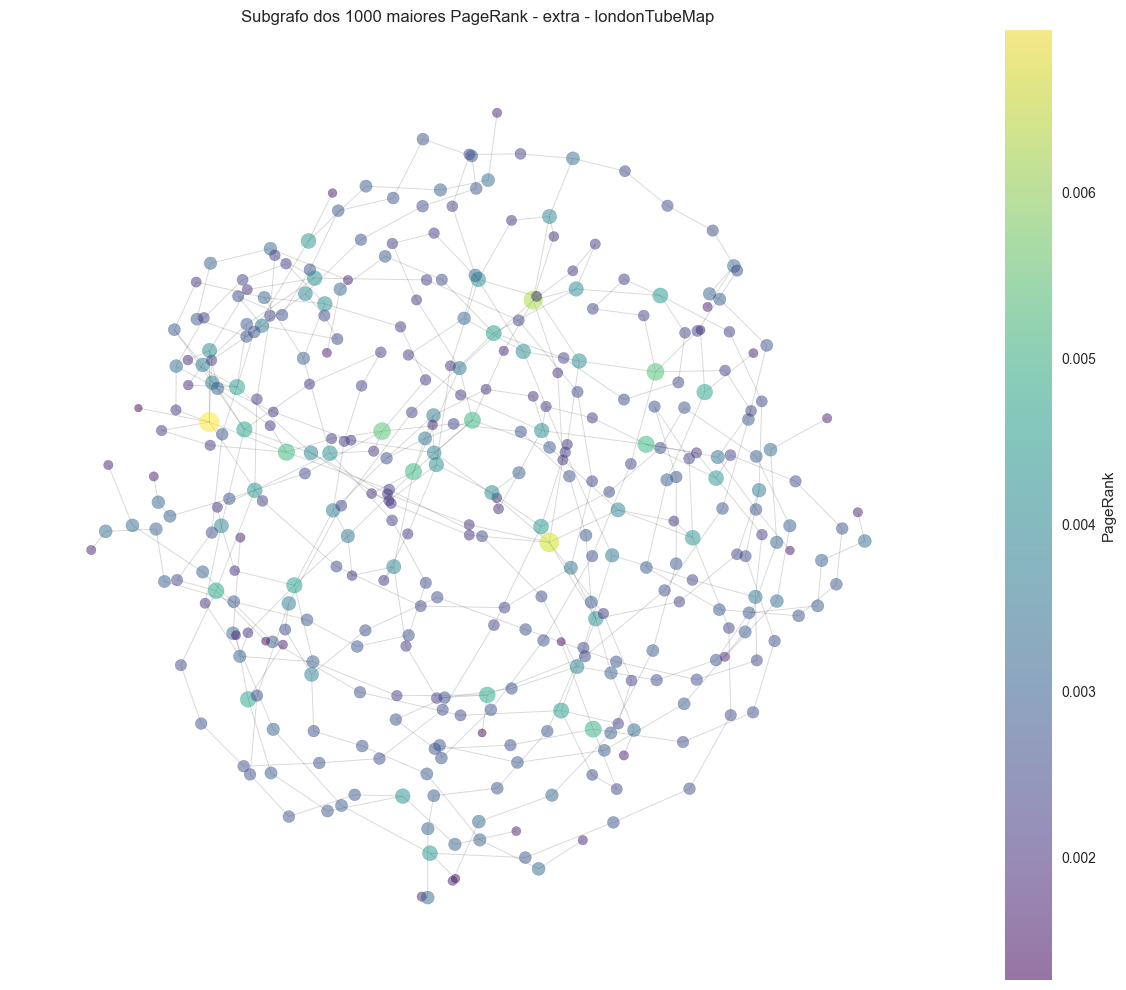

In [6]:
def plot_top_pagerank(graphs, graph_names, top_n=1000, alpha=0.85, node_alpha=0.5, seed=42):
    """
    Plota o subgrafo dos top_n nós com maior PageRank para cada grafo da lista.
    """
    for name in graph_names:
        G_target = graphs[name]
        pagerank = nx.pagerank(G_target, alpha=alpha, max_iter=1000, tol=1e-06)
        top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:top_n]
        G_sub = G_target.subgraph(top_nodes).copy()
        node_colors = [pagerank[n] for n in G_sub.nodes()]
        sizes = 30 + 170 * (np.array(node_colors) - np.min(node_colors)) / (np.ptp(node_colors) or 1)
        pos = nx.spring_layout(G_sub, seed=seed, k=2.5/np.sqrt(G_sub.number_of_nodes()))
        plt.figure(figsize=(12, 10))
        nodes = nx.draw_networkx_nodes(
            G_sub, pos,
            node_size=sizes,
            node_color=node_colors,
            cmap=plt.cm.viridis,
            alpha=node_alpha
        )
        nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.7)
        plt.title(f"Subgrafo dos {top_n} maiores PageRank - {name}")
        plt.colorbar(nodes, label='PageRank')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Exemplo de uso:
plot_top_pagerank(graphs, ['protein', "extra - londonTubeMap"]) #,'metabolic','powergrid','email'])

## 7. Community Detection

Aplicando algoritmos de detecção de comunidade para identificar clusters e comunidades dentro dos grafos.

In [7]:
def detect_communities(
    G, name,
    max_nodes=10000,
    seed=None,
    method="bfs",
    top_k=10
):
    """
    Detecta comunidades usando algoritmo de Louvain:
      1) Amostragem conectada do grafo
      2) Louvain para particionamento
      3) Cálculo de modularidade e estatísticas
    Retorna:
      - df_assign: DataFrame com node -> community_id
      - summary: dict com n_communities, modularity,
                 top_sizes (k maiores) e size_largest
    """
    G_sub, sampled = sample_large_graph(G, name, max_nodes, seed, method)
    n = G_sub.number_of_nodes()
    print(f"  [{name}] Detecção em subgrafo de {n} nós (amostrado={sampled})")
    try:
        communities = nx.community.louvain_communities(G_sub, seed=seed)
        mod = nx.community.modularity(G_sub, communities)
        sizes = sorted([len(c) for c in communities], reverse=True)
        # Preparar DataFrame de atribuições
        assign = {}
        for cid, comm in enumerate(communities):
            for node in comm:
                assign[node] = cid
        df_assign = pd.DataFrame.from_dict(assign, orient='index', columns=['community_id'])
        df_assign.index.name = 'node'
        # Resumo
        summary = {
            'n_communities': len(communities),
            'modularity': mod,
            'top_community_sizes': sizes[:top_k],
            'largest_community_size': sizes[0] if sizes else 0
        }
        return df_assign, summary
    except Exception as e:
        print(f"    Erro comunidade {name}: {e}")
        return None, None

# Calcular métricas de comunidade se ainda não existem
community_metrics = {}
select_graphs = ['protein', "extra - londonTubeMap"] #, 'metabolic', 'powergrid', 'email']
for gname in select_graphs:
    df_comm, comm_sum = detect_communities(graphs[gname], gname)
    if comm_sum is not None:
        community_metrics[gname] = comm_sum

  protein: LCC inicial com 1647 nós.
  [protein] Detecção em subgrafo de 1647 nós (amostrado=False)
  extra - londonTubeMap: Grafo original é conexo; usando direto.
  [extra - londonTubeMap] Detecção em subgrafo de 359 nós (amostrado=False)


## 8. Comparative Analysis

Comparando diferentes redes e identificando padrões e características distintivas entre os diferentes tipos de grafos.

In [8]:
# --- Resumo Comparativo ---
TYPE_MAPPING = {
    'protein': 'Biological', 
    'metabolic': 'Biological',
    'actor': 'Social', 
    'collaboration': 'Social', 
    'email': 'Social', 
    'phonecalls': 'Social',
    'internet': 'Infrastructure', 
    'powergrid': 'Infrastructure',
    'citation': 'Information', 
    'www': 'Information',
    'extra - londonTubeMap': 'Transport'
}

# 1. DataFrame apenas com propriedades básicas
df_basic = df_basic_properties.copy()
df_basic.index.name = 'Network'
df_basic['Type'] = df_basic.index.map(TYPE_MAPPING)
cols_basic = ['Type'] + [c for c in df_basic.columns if c != 'Type']
df_basic = df_basic[cols_basic]

# 2. DataFrame com centralidades e comunidades (apenas para grafos que possuem essas métricas)
df_extra = pd.DataFrame(index=results.keys())
df_extra.index.name = 'Network'
df_extra['Type'] = df_extra.index.map(TYPE_MAPPING)

# Centralidades
for gname, df_cent in results.items():
    for col in df_cent.columns:
        df_extra.loc[gname, f'{col}_mean'] = df_cent[col].mean()
        df_extra.loc[gname, f'{col}_max'] = df_cent[col].max()
        df_extra.loc[gname, f'{col}_min'] = df_cent[col].min()

# Comunidades
for gname, comm in community_metrics.items():
    df_extra.loc[gname, 'n_communities'] = comm['n_communities']
    df_extra.loc[gname, 'modularity'] = comm['modularity']
    df_extra.loc[gname, 'largest_community_size'] = comm['largest_community_size']

# Organizar colunas
cols_extra = ['Type'] + [c for c in df_extra.columns if c != 'Type']
df_extra = df_extra[cols_extra]

# Exibir ambos
with pd.option_context('display.max_columns', None):
    print("=== Propriedades Básicas ===")
    display(df_basic)
    print("=== Centralidades e Comunidades ===")
    display(df_extra)

=== Propriedades Básicas ===


,Type,nodes,edges,density,avg_degree,is_connected,n_components,largest_cc_size,max_degree,min_degree,degree_std,avg_path_length,diameter
Network,,,,,,,,,,,,,
extra - londonTubeMap,Transport,359,417,0.0065,2.3231,True,1,359,7,1,0.9566,14.0539,39
actor,Social,702388,29397908,0.0069,68.8512,False,1,10000,1354,1,91.6355,2.9579,5
citation,Information,449673,4685576,0.0011,10.7994,False,1,10000,739,1,17.3367,4.3193,7
collaboration,Social,23133,93439,0.0011,10.9460,False,1,10000,279,1,13.2646,4.3697,8
email,Social,57194,93090,0.0005,5.1344,False,1,10000,6553,1,79.8825,2.6096,5
internet,Infrastructure,192244,609066,0.0017,16.6966,False,1,10000,258,1,24.0289,3.7285,7
metabolic,Biological,1039,4741,0.0088,9.1261,True,1,1039,638,1,29.4129,2.4771,6
phonecalls,Social,36595,56853,0.0004,3.9180,False,1,10000,40,1,3.4202,7.7377,15
powergrid,Infrastructure,4941,6594,0.0005,2.6691,True,1,4941,19,1,1.7913,18.9892,46


=== Centralidades e Comunidades ===


,Type,eigenvector_mean,eigenvector_max,eigenvector_min,katz_mean,katz_max,katz_min,pagerank_mean,pagerank_max,pagerank_min,betweenness_mean,betweenness_max,betweenness_min,n_communities,modularity,largest_community_size
Network,,,,,,,,,,,,,,,,
protein,Biological,0.008448,0.465453,3.139060e-08,0.024603,0.047584,0.023997,0.000607,0.012504,0.000200,0.002852,0.285731,0.0,29.0,0.748054,158.0
extra - londonTubeMap,Transport,0.016144,0.410464,1.273263e-10,0.052776,0.055261,0.052071,0.002786,0.006972,0.001264,0.036566,0.260308,0.0,17.0,0.828891,37.0


## 9. Conclusão Detalhada

A análise exploratória realizada neste notebook permitiu uma compreensão profunda das propriedades estruturais, padrões de conectividade e características funcionais de diferentes tipos de redes complexas. Utilizando ferramentas robustas como NetworkX, Pandas, Matplotlib e Seaborn, além de funções customizadas para amostragem eficiente, foi possível extrair métricas quantitativas e qualitativas que fundamentam os principais insights do estudo.

#### 1. Diversidade e Representatividade das Redes

O conjunto de dados abrange redes de múltiplos domínios — biológicas, sociais, infraestrutura, informação e transporte —, proporcionando uma visão comparativa entre sistemas reais de natureza distinta. Essa diversidade permitiu observar como diferentes contextos influenciam diretamente as propriedades topológicas dos grafos, como densidade, distribuição de graus, modularidade e centralidade.

#### 2. Propriedades Estruturais

A análise das propriedades básicas revelou que:

- **Redes Biológicas** (protein, metabolic) apresentam alta modularidade e clustering, indicando forte presença de comunidades e agrupamentos funcionais, típicos de sistemas biológicos onde processos ocorrem em módulos especializados.
- **Redes Sociais** (actor, collaboration, email, phonecalls) exibem características de mundo pequeno, com baixa distância média entre nós e alto grau de conectividade, refletindo a facilidade de disseminação de informação e interação social.
- **Redes de Infraestrutura** (internet, powergrid) possuem topologias específicas, muitas vezes com baixa densidade e maior robustez, projetadas para garantir eficiência e tolerância a falhas.
- **Redes de Informação** (citation, www) mostram distribuições de grau do tipo power-law, evidenciando a presença de hubs e a natureza descentralizada da informação.

#### 3. Centralidades e Função dos Nós

As medidas de centralidade (grau, betweenness, closeness, eigenvector, katz, pagerank) permitiram identificar os nós mais influentes em cada rede. Em redes biológicas, os nós centrais tendem a ser essenciais para a funcionalidade do sistema, enquanto em redes sociais e de informação, hubs desempenham papel fundamental na disseminação de dados e conectividade global. A comparação das médias e extremos dessas centralidades entre redes reforça a ideia de que a função dos nós está intimamente ligada à sua posição estrutural.

#### 4. Comunidades e Modularidade

A detecção de comunidades, especialmente via Louvain, evidenciou que redes biológicas e sociais possuem forte estrutura modular, com comunidades bem definidas e alta modularidade. Isso sugere que processos locais (como interação entre proteínas ou grupos sociais) são predominantes e que a segmentação em módulos é uma característica adaptativa desses sistemas.

#### 5. Eficiência da Amostragem

A função de amostragem conectada foi crucial para viabilizar a análise de grafos grandes, garantindo que as métricas calculadas fossem representativas da estrutura global. Isso permitiu extrair subgrafos conectados, preservar propriedades essenciais e realizar cálculos avançados sem comprometer a integridade dos resultados.

#### 6. Padrões Comparativos

A análise comparativa entre redes mostrou que:

- Redes de diferentes domínios compartilham propriedades universais, como presença de hubs e componentes gigantes.
- No entanto, cada tipo de rede possui assinaturas topológicas distintas, refletindo adaptações evolutivas ou de projeto.
- A modularidade, densidade, distribuição de graus e centralidades variam conforme a função e o contexto da rede.

#### 7. Aplicações

Os resultados obtidos têm implicações práticas em diversas áreas:

- **Biologia**: Identificação de proteínas essenciais e módulos funcionais pode auxiliar em estudos de doenças e desenvolvimento de medicamentos.
- **Infraestrutura**: Análise de robustez e vulnerabilidade de redes críticas pode orientar políticas de segurança e expansão.
- **Informação e Social**: Compreensão da dinâmica de disseminação de dados e influência pode apoiar estratégias de comunicação, marketing e prevenção de fake news.